# SPH6004 Group project Task 1 (Multi-label Classification Model) - Part 1

This file is for SPH6004 Group project 
Task 1 (Multi-label Classification Model) - Logistic Regression. 
We use logistic regression as a baseline model for comparison with MLP. 
Since logistic regression can be viewed as a simple neural network without hidden layers, it provides a useful reference point to assess how much performance improves with deeper architectures.


In [2]:
pip install numpy pandas torch torchvision torchaudio tensorflow opencv-python pydicom matplotlib openpyxl seaborn


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
###Load packages
import os
import os.path
import random

import numpy as np
import pandas as pd
from typing import Dict, List
import torch
from torch.utils.data import Dataset
import tensorflow as tf

In [4]:
###Define helper functions for dataset class

def load_embedding(embedding_path):
    raw_dataset = tf.data.TFRecordDataset([embedding_path])
    for raw_record in raw_dataset.take(1):
      example = tf.train.Example()
      example.ParseFromString(raw_record.numpy())
      embedding_feature = example.features.feature['embedding']
      embedding_values = embedding_feature.float_list.value
    return torch.tensor(embedding_values)


In [5]:
####Define Dataset Class 
##Here, a list is defined containing a series of diseases (pathologies), which are pathology labels in the dataset.
# These medical imaging labels are typically used for classification tasks (such as diagnosing whether an X-ray shows pneumonia, pleural effusion, etc.).


class MIMIC_Embed_Dataset(Dataset):

    pathologies = [
        "Enlarged Cardiomediastinum",
        "Cardiomegaly",
        "Lung Opacity",
        "Lung Lesion",
        "Edema",
        "Consolidation",
        "Pneumonia",
        "Atelectasis",
        "Pneumothorax",
        "Pleural Effusion",
        "Pleural Other",
        "Fracture",
        "Support Devices",
    ]


#80% training data (train)
#10% validation data (valid)
#10% test data (test)
    split_ratio = [0.8, 0.1, 0.1]

    def __init__(
        self,
        embedpath,
        csvpath,
        metacsvpath,
        views=["PA"],
        data_aug=None,
        seed=0,
        unique_patients=True,
        mode=["train", "valid", "test"][0],
    ):

        super().__init__()
        np.random.seed(seed)  # Reset the seed so all runs are the same.
        #Ensures NumPy-based randomness is reproducible.

        self.pathologies = sorted(self.pathologies)

        self.mode = mode
        self.embedpath = embedpath
        self.data_aug = data_aug
        self.csvpath = csvpath
        self.csv = pd.read_csv(self.csvpath)
        self.metacsvpath = metacsvpath
        self.metacsv = pd.read_csv(self.metacsvpath)

        self.csv = self.csv.set_index(["subject_id", "study_id"])
        self.metacsv = self.metacsv.set_index(["subject_id", "study_id"])

        self.csv = self.csv.join(self.metacsv).reset_index()

        # Keep only the desired view
        self.csv["view"] = self.csv["ViewPosition"]
        self.limit_to_selected_views(views)

        if unique_patients:
            self.csv = self.csv.groupby("subject_id").first().reset_index()

        n_row = self.csv.shape[0]
        
     

        # spit data to one of train valid test
        if self.mode == "train":
            self.csv = self.csv[: int(n_row * self.split_ratio[0])]
        elif self.mode == "valid":
            self.csv = self.csv[
                int(n_row * self.split_ratio[0]) : int(
                    n_row * (self.split_ratio[0] + self.split_ratio[1])
                )
            ]
        elif self.mode == "test":
            self.csv = self.csv[-int(n_row * self.split_ratio[-1]) :]
        else:
            raise ValueError(
                f"attr:mode has to be one of [train, valid, test] but your input is {self.mode}"
            )

        # Get our classes.
        healthy = self.csv["No Finding"] == 1 
        labels = []
        for pathology in self.pathologies:
            if pathology in self.csv.columns:
                self.csv.loc[healthy, pathology] = 0 
                mask = self.csv[pathology]

            labels.append(mask.values)
        self.labels = np.asarray(labels).T
        self.labels = self.labels.astype(np.float32)

        # Make all the -1 values into nans to keep things simple
        self.labels[self.labels == -1] = np.nan  

        # Rename pathologies
        self.pathologies = list(
            np.char.replace(self.pathologies, "Pleural Effusion", "Effusion")
        )

        # add consistent csv values

       
        self.csv["offset_day_int"] = self.csv["StudyDate"]

        # patientid
        self.csv["patientid"] = self.csv["subject_id"].astype(str)

    def string(self):
        return self.__class__.__name__ + " num_samples={} views={}".format(
            len(self), self.views,
        )

    def limit_to_selected_views(self, views):
        """This function is called by subclasses to filter the
        images by view based on the values in .csv['view']
        """
        if type(views) is not list:
            views = [views]
        if '*' in views:
            # if you have the wildcard, the rest are irrelevant
            views = ["*"]
        self.views = views

        # missing data is unknown
        self.csv.view.fillna("UNKNOWN", inplace=True)

        if "*" not in views:
            self.csv = self.csv[self.csv["view"].isin(self.views)]  # Select the view

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = {}
        sample["idx"] = idx
        sample["lab"] = self.labels[idx]

        subjectid = str(self.csv.iloc[idx]["subject_id"]) 
        studyid = str(self.csv.iloc[idx]["study_id"]) 
        dicom_id = str(self.csv.iloc[idx]["dicom_id"]) 


        #data_aug
        embed_file = os.path.join(
            self.embedpath,
            "p" + subjectid[:2],
            "p" + subjectid,
            "s" + studyid,
            dicom_id + ".tfrecord",
        )
        sample["embedding"] = load_embedding(embed_file) 
        #sample["embedding"] = embed_file

        return sample

In [6]:

# Define correct file paths
#embedpath = "/Users/jiawei/Desktop/SPH6004/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/files"
#csvpath = "/Users/jiawei/Desktop/SPH6004/mimic-cxr-2.0.0-chexpert.csv"
#metacsvpath = "/Users/jiawei/Desktop/SPH6004/mimic-cxr-2.0.0-metadata.csv"



# Define correct file paths (Windows version)
embedpath = "C:\\Users\\wujia\\Desktop\\SPH6004\\Group Project\\generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0\\files"
csvpath = "C:\\Users\\wujia\\Desktop\\SPH6004\\Group Project\\mimic-cxr-2.0.0-chexpert.csv"
metacsvpath = "C:\\Users\\wujia\\Desktop\\SPH6004\\Group Project\\mimic-cxr-2.0.0-metadata.csv"


# Verify the paths exist
import os
print("Embed Path Exists:", os.path.exists(embedpath))
print("CSV Path Exists:", os.path.exists(csvpath))
print("Metadata CSV Path Exists:", os.path.exists(metacsvpath))



Embed Path Exists: True
CSV Path Exists: True
Metadata CSV Path Exists: True


In [7]:

dataset = MIMIC_Embed_Dataset(embedpath,csvpath,metacsvpath,mode = "train")


In [8]:
sample = dataset[1000]
sample


{'idx': 1000,
 'lab': array([nan,  1., nan, nan, nan,  1., nan,  1., nan, nan, nan,  1.,  0.],
       dtype=float32),
 'embedding': tensor([-0.6009, -2.6448,  1.1589,  ...,  0.3574,  1.4271, -2.1083])}

# 1.Exploratory Data Analysis 

In [9]:

print(len(dataset))


36502


From above result : 
The dataset（80% training) contains 36,502 samples.
Meaning : Valid (10%) → 4,562 samples / Test (10%) → 4,562 samples 
full_size = 36502 / 0.8  # ≈ 45,627 samples 

1.1 Exploring Mimic-cxr-2.0.0-chexpert 

In [10]:
#####Exploring
import pandas as pd

# Load the CSV file
chexpert_df = pd.read_csv(csvpath)

# Show the first few rows
print("CSV File Structure:")
display(chexpert_df.head())

# Show column names
print("\nColumns in CSV File:", chexpert_df.columns)


CSV File Structure:


,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,10000032,56699142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,10000764,57375967,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN



Columns in CSV File: Index(['subject_id', 'study_id', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
       'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
       'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices'],
      dtype='object')


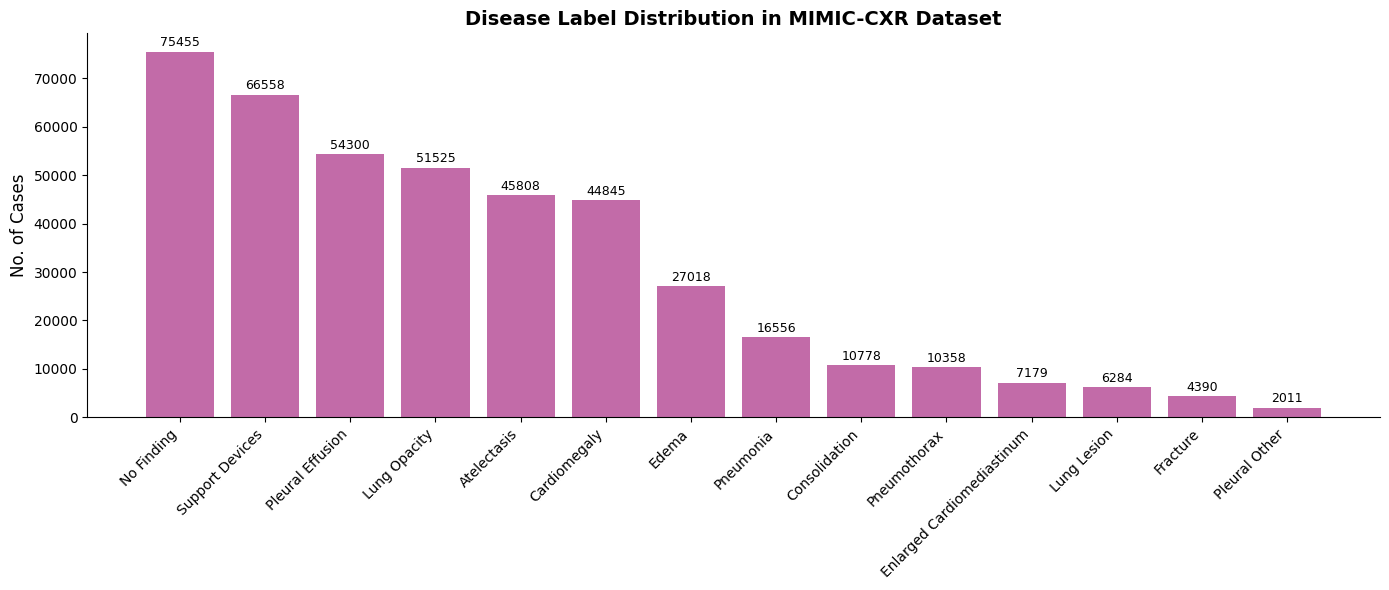

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
csvpath = "C:\\Users\\wujia\\Desktop\\SPH6004\\Group Project\\mimic-cxr-2.0.0-chexpert.csv"
#csvpath = "/Users/jiawei/Desktop/SPH6004/mimic-cxr-2.0.0-chexpert.csv"
df = pd.read_csv(csvpath)

# Replace -1 with NaN
df.replace(-1.0, np.nan, inplace=True)

# Labels
pathologies = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity", "No Finding", "Pleural Effusion",
    "Pleural Other", "Pneumonia", "Pneumothorax", "Support Devices"
]

# Count positive cases
label_counts = {label: (df[label] == 1.0).sum() for label in pathologies}
sorted_counts = dict(sorted(label_counts.items(), key=lambda x: x[1], reverse=True))

# Plot
plt.figure(figsize=(14, 6))

bars = plt.bar(sorted_counts.keys(), sorted_counts.values(), color='#c26ba8') 
# Add count labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 500, f"{int(yval)}",
             ha='center', va='bottom', fontsize=9, color='black')

# Style
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title("Disease Label Distribution in MIMIC-CXR Dataset", fontsize=14, fontweight='bold')


# Remove axis labels
plt.xlabel("")
plt.ylabel("No. of Cases", fontsize=12)

# Remove top and right border (spines)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove grid
plt.grid(False)

plt.tight_layout()
plt.show()


1.2 Exploring metadata

In [12]:
# Load the metadata CSV file
meta_df = pd.read_csv(metacsvpath)

# Show the first few rows
print("Metadata CSV File Structure:")
display(meta_df.head(10))

# Show column names
print("\nColumns in Metadata CSV File:", meta_df.columns)


Metadata CSV File Structure:


,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,50414267,CHEST (PA AND LAT),PA,3056,2544,21800506,213014.531,CHEST (PA AND LAT),postero-anterior,Erect
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,10000032,50414267,CHEST (PA AND LAT),LATERAL,3056,2544,21800506,213014.531,CHEST (PA AND LAT),lateral,Erect
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032,53189527,CHEST (PA AND LAT),PA,3056,2544,21800626,165500.312,CHEST (PA AND LAT),postero-anterior,Erect
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,10000032,53189527,CHEST (PA AND LAT),LATERAL,3056,2544,21800626,165500.312,CHEST (PA AND LAT),lateral,Erect
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762,CHEST (PORTABLE AP),AP,2705,2539,21800723,80556.875,CHEST (PORTABLE AP),antero-posterior,NaN
5,fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818,10000032,53911762,CHEST (PORTABLE AP),AP,2906,2258,21800723,80556.875,CHEST (PORTABLE AP),antero-posterior,Erect
6,ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c,10000032,56699142,CHEST (PORTABLE AP),AP,3056,2544,21800805,234424.765,CHEST (PORTABLE AP),antero-posterior,NaN
7,096052b7-d256dc40-453a102b-fa7d01c6-1b22c6b4,10000764,57375967,CHEST (PA AND LAT),AP,2544,3056,21321015,84047.984,CHEST (PA AND LAT),antero-posterior,Erect
8,b79e55c3-735ce5ac-64412506-cdc9ea79-f1af521f,10000764,57375967,CHEST (PA AND LAT),LATERAL,3056,2544,21321015,84047.984,CHEST (PA AND LAT),lateral,Erect
9,dcfeeac4-1597e318-d0e6736a-8b2c2238-47ac3f1b,10000764,57375967,CHEST (PA AND LAT),LATERAL,3056,2544,21321015,84047.984,CHEST (PA AND LAT),lateral,Erect



Columns in Metadata CSV File: Index(['dicom_id', 'subject_id', 'study_id',
       'PerformedProcedureStepDescription', 'ViewPosition', 'Rows', 'Columns',
       'StudyDate', 'StudyTime', 'ProcedureCodeSequence_CodeMeaning',
       'ViewCodeSequence_CodeMeaning',
       'PatientOrientationCodeSequence_CodeMeaning'],
      dtype='object')


In [13]:
subject_id = str(dataset.csv.iloc[0]["subject_id"])
study_id = str(dataset.csv.iloc[0]["study_id"])
dicom_id = str(dataset.csv.iloc[0]["dicom_id"])

embed_file = os.path.join(
    embedpath,
    "p" + subject_id[:2],
    "p" + subject_id,
    "s" + study_id,
    dicom_id + ".tfrecord",
)

print("Embedding File Path:", embed_file)
print("File Exists:", os.path.exists(embed_file))

#dicom_id column (e.g. 02aa804e-bde0afdd-112c0b34-7bc16630-4e384014 matches the filename of the .tfrecord embedding file)
#meaning each DICOM ID corresponds to a .tfrecord file that contains its image embedding. 


Embedding File Path: C:\Users\wujia\Desktop\SPH6004\Group Project\generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0\files\p10\p10000032\s50414267\02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.tfrecord
File Exists: True


In [14]:
# Select 5 samples to see the overall structure of the dataset. 
#Check embedding size 

import random
random_indices = random.sample(range(len(dataset)), 5)

# Show 5 random samples
for idx in random_indices:
    sample = dataset[idx]
    print(f"Sample {idx}:\n  Labels: {sample['lab']}\n  Embedding shape: {sample['embedding'].shape}\n")
    
    

Sample 24005:
  Labels: [nan  1. nan nan nan nan nan nan  1. nan nan  0.  0.]
  Embedding shape: torch.Size([1376])

Sample 28163:
  Labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Embedding shape: torch.Size([1376])

Sample 21038:
  Labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Embedding shape: torch.Size([1376])

Sample 164:
  Labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Embedding shape: torch.Size([1376])

Sample 28188:
  Labels: [nan  1.  1.  0. nan nan nan  1.  0. nan  1.  0. nan]
  Embedding shape: torch.Size([1376])



In [15]:
# Count unique values in dicom_id, study_id, and subject_id
unique_dicom = meta_df["dicom_id"].nunique()
unique_study = meta_df["study_id"].nunique()
unique_subject = meta_df["subject_id"].nunique()

# Print results
print(f"Number of unique dicom_id: {unique_dicom}")
print(f"Number of unique study_id: {unique_study}")
print(f"Number of unique subject_id: {unique_subject}")

#Check number of .tfrecord files 
all_tfrecord_files = [f for root, _, files in os.walk(embedpath) for f in files if f.endswith(".tfrecord")]
print(f"Total .tfrecord files in the dataset: {len(all_tfrecord_files)}")

#subject_id (65,379 unique values): Represents individual patients. Each subject_id may have multiple study_id values (i.e., multiple examinations).
#study_id (227,835 unique values): Represents each imaging examination. Each study_id may contain multiple dicom_id values (i.e., multiple images).
#dicom_id (377,110 unique values): Represents individual DICOM image files. Each examination (study_id) may include multiple images taken from different views (e.g., PA, LAT),
#which results in multiple dicom_id values corresponding to a single study_id.
#The dataset contains 377,110 images corresponding to 227,835 radiographic studies" From https://physionet.org/content/mimic-cxr/2.1.0/

Number of unique dicom_id: 377110
Number of unique study_id: 227835
Number of unique subject_id: 65379
Total .tfrecord files in the dataset: 243324


# 2.Using Logistic Regression as a baseline classifier on pre-extracted embeddings. 

In [16]:
train_dataset = MIMIC_Embed_Dataset(embedpath, csvpath, metacsvpath, mode="train")
val_dataset   = MIMIC_Embed_Dataset(embedpath, csvpath, metacsvpath, mode="valid")
test_dataset  = MIMIC_Embed_Dataset(embedpath, csvpath, metacsvpath, mode="test")

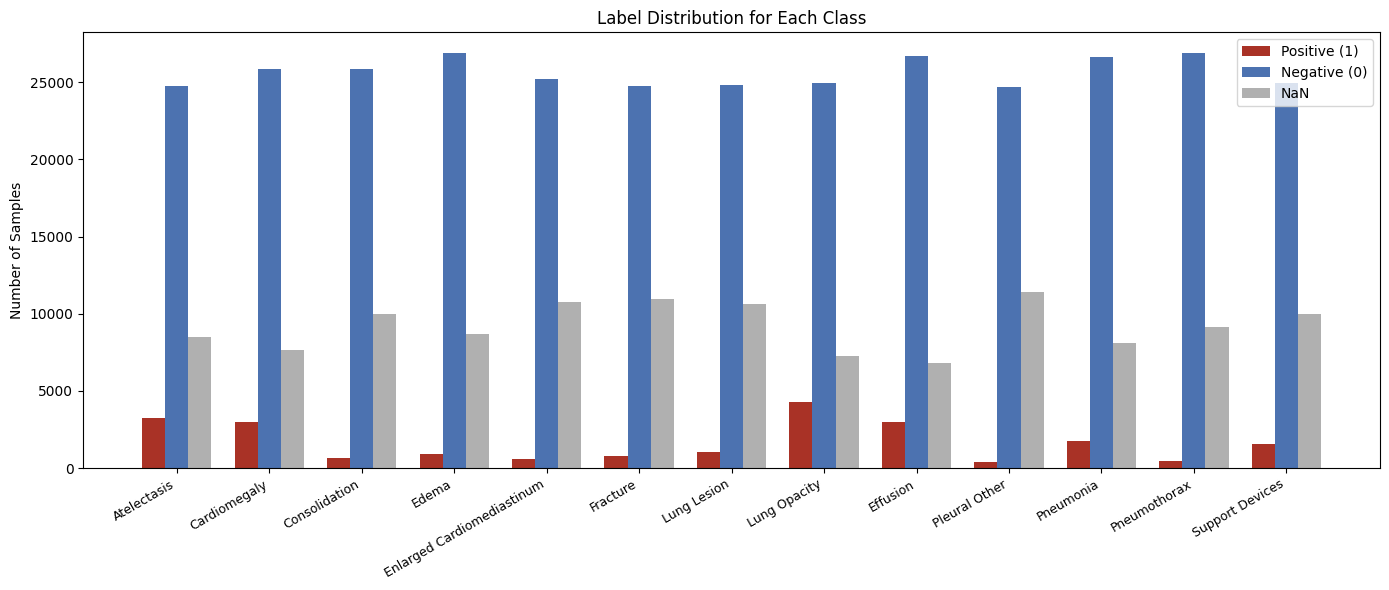

In [17]:
# Check label distribution for each class on training dataset 
import matplotlib.pyplot as plt
import numpy as np

# Number of classes and class names
num_classes = len(train_dataset.pathologies)
class_names = train_dataset.pathologies

# Count positive, negative, and NaN samples for each class
pos_counts = []
neg_counts = []
nan_counts = []

for i in range(num_classes):
    labels = train_dataset.labels[:, i]
    pos_counts.append(np.sum(labels == 1))
    neg_counts.append(np.sum(labels == 0))
    nan_counts.append(np.sum(np.isnan(labels)))

# Plotting
x = np.arange(num_classes)
width = 0.25

plt.figure(figsize=(14, 6))
plt.bar(x - width, pos_counts, width, label='Positive (1)', color='#A93226')
plt.bar(x, neg_counts, width, label='Negative (0)', color='#4C72B0')
plt.bar(x + width, nan_counts, width, label='NaN', color='#B0B0B0')

plt.xticks(x, class_names, rotation=30, ha='right', fontsize=9)
plt.ylabel('Number of Samples')
plt.title('Label Distribution for Each Class')
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
#Train Logistic Regression on Embeddings - extract embeddings (X) and corresponding labels (y) from each dataset object

import numpy as np

# Extract X and y from train/val/test sets
def extract_X_y(dataset):
    X = []
    y = []
    for sample in dataset:
        X.append(sample['embedding'].numpy()) ####convert torch to Numpy 
        y.append(sample['lab'])  
    return np.array(X), np.array(y)

X_train, y_train = extract_X_y(train_dataset)
X_val, y_val = extract_X_y(val_dataset)
X_test, y_test = extract_X_y(test_dataset)


In [19]:
# Perform normalization as a precaution (in case embeddings are not pre-normalized)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score
import numpy as np

n_classes = y_train.shape[1]
aucs = []
f1s = []
recalls = []
precisions = []
models = []
y_val_probs = []  
y_val_truths = [] 

pathologies = [
        "Enlarged Cardiomediastinum",
        "Cardiomegaly",
        "Lung Opacity",
        "Lung Lesion",
        "Edema",
        "Consolidation",
        "Pneumonia",
        "Atelectasis",
        "Pneumothorax",
        "Pleural Effusion",
        "Pleural Other",
        "Fracture",
        "Support Devices",
    ]


for i in range(n_classes):
    print(f"Training class {i} ({pathologies[i]})...")

    # ignore NaN label
    mask = ~np.isnan(y_train[:, i])
    Xi, yi = X_train_scaled[mask], y_train[mask, i]
    # Sets a random seed for reproducibility (ensures consistent results each run)
    # Maximum number of iterations(1000) for the solver to converge
    clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    clf.fit(Xi, yi) # Train the logistic regression model on the training set (class i)

    # Validation set prediction
    y_val_prob = clf.predict_proba(X_val_scaled)[:, 1] # Predict the probability of class 1 (positive class) for each sample in the validation set
    mask_val = ~np.isnan(y_val[:, i])
    y_true = y_val[mask_val, i]
    y_score = y_val_prob[mask_val]
    y_pred = (y_score >= 0.5).astype(int)  # set fixed threshold = 0.5

    # Evaluation 
    auc = roc_auc_score(y_true, y_score)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    precision = precision_score(y_true, y_pred, zero_division=0)

    aucs.append(auc)
    f1s.append(f1)
    recalls.append(recall)
    precisions.append(precision)
    models.append(clf)
    y_val_probs.append(y_score)
    y_val_truths.append(y_true)

    print(f"Class {i}: AUC = {auc:.4f}, F1 = {f1:.4f}, Recall = {recall:.4f}, Precision = {precision:.4f}")


print(f"\nAverage AUC: {np.mean(aucs):.4f}")
print(f"Average F1-score: {np.mean(f1s):.4f}")
print(f"Average Recall: {np.mean(recalls):.4f}")
print(f"Average Precision: {np.mean(precisions):.4f}")


Training class 0 (Enlarged Cardiomediastinum)...
Class 0: AUC = 0.8723, F1 = 0.5033, Recall = 0.7506, Precision = 0.3785
Training class 1 (Cardiomegaly)...
Class 1: AUC = 0.8935, F1 = 0.4934, Recall = 0.7756, Precision = 0.3618
Training class 2 (Lung Opacity)...
Class 2: AUC = 0.8262, F1 = 0.2867, Recall = 0.4725, Precision = 0.2057
Training class 3 (Lung Lesion)...
Class 3: AUC = 0.8739, F1 = 0.3171, Recall = 0.4906, Precision = 0.2342
Training class 4 (Edema)...
Class 4: AUC = 0.7738, F1 = 0.1325, Recall = 0.2899, Precision = 0.0858
Training class 5 (Consolidation)...
Class 5: AUC = 0.6839, F1 = 0.1216, Recall = 0.3529, Precision = 0.0735
Training class 6 (Pneumonia)...
Class 6: AUC = 0.7892, F1 = 0.2536, Recall = 0.5298, Precision = 0.1667
Training class 7 (Atelectasis)...
Class 7: AUC = 0.8372, F1 = 0.5166, Recall = 0.7279, Precision = 0.4004
Training class 8 (Pneumothorax)...
Class 8: AUC = 0.9382, F1 = 0.6032, Recall = 0.8539, Precision = 0.4664
Training class 9 (Pleural Effusion

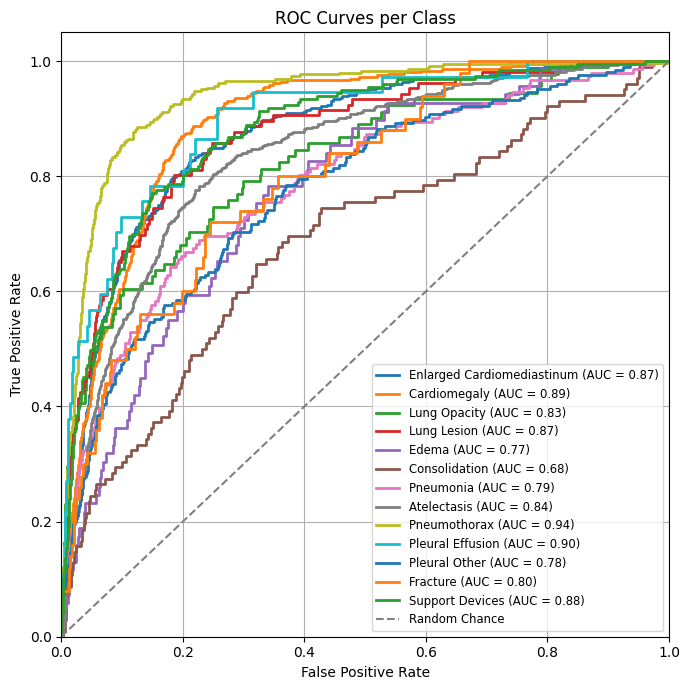

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_val_truths[i], y_val_probs[i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{pathologies[i]} (AUC = {roc_auc:.2f})')

# Plot chance line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Chance')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Class')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()



The training results shown above are evaluated on the validation dataset. No further tuning will be performed as Logistic Regression is not the target model for Task 1. Instead, we plan to use a newly learned neural network model for this task. Therefore, the current LR model will be used as the final version for evaluation on the test dataset.

In [22]:
# ===== Evaluate on test set =====
test_aucs = []
test_f1s = []
test_recalls = []
test_precisions = []
y_test_probs = []
y_test_truths = []

pathologies = [
        "Enlarged Cardiomediastinum",
        "Cardiomegaly",
        "Lung Opacity",
        "Lung Lesion",
        "Edema",
        "Consolidation",
        "Pneumonia",
        "Atelectasis",
        "Pneumothorax",
        "Pleural Effusion",
        "Pleural Other",
        "Fracture",
        "Support Devices",
    ]

for i in range(n_classes):
    print(f"class {i} ({pathologies[i]})...")
    clf = models[i]  # test on trained models (13 types)

    y_test_prob = clf.predict_proba(X_test_scaled)[:, 1]

  
    mask_test = ~np.isnan(y_test[:, i])
    y_true = y_test[mask_test, i]
    y_score = y_test_prob[mask_test]
    y_pred = (y_score >= 0.5).astype(int)  #  threshold = 0.5

    # For ploting ROC
    y_test_probs.append(y_score)
    y_test_truths.append(y_true)

    # Evaluation metrics
    auc = roc_auc_score(y_true, y_score)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    precision = precision_score(y_true, y_pred, zero_division=0)

    # save results 
    test_aucs.append(auc)
    test_f1s.append(f1)
    test_recalls.append(recall)
    test_precisions.append(precision)

    print(f"Test Class {i}: AUC = {auc:.4f}, F1 = {f1:.4f}, Recall = {recall:.4f}, Precision = {precision:.4f}")


print("\n--- Test Set Overall Performance ---")
print(f"Average AUC: {np.mean(test_aucs):.4f}")
print(f"Average F1-score: {np.mean(test_f1s):.4f}")
print(f"Average Recall: {np.mean(test_recalls):.4f}")
print(f"Average Precision: {np.mean(test_precisions):.4f}")


    


class 0 (Enlarged Cardiomediastinum)...
Test Class 0: AUC = 0.8759, F1 = 0.5283, Recall = 0.7534, Precision = 0.4068
class 1 (Cardiomegaly)...
Test Class 1: AUC = 0.8939, F1 = 0.5309, Recall = 0.7950, Precision = 0.3985
class 2 (Lung Opacity)...
Test Class 2: AUC = 0.8552, F1 = 0.2556, Recall = 0.4533, Precision = 0.1780
class 3 (Lung Lesion)...
Test Class 3: AUC = 0.9147, F1 = 0.3915, Recall = 0.6016, Precision = 0.2902
class 4 (Edema)...
Test Class 4: AUC = 0.6796, F1 = 0.1155, Recall = 0.2714, Precision = 0.0734
class 5 (Consolidation)...
Test Class 5: AUC = 0.7158, F1 = 0.1246, Recall = 0.4390, Precision = 0.0726
class 6 (Pneumonia)...
Test Class 6: AUC = 0.8132, F1 = 0.2275, Recall = 0.5583, Precision = 0.1429
class 7 (Atelectasis)...
Test Class 7: AUC = 0.8542, F1 = 0.5502, Recall = 0.7465, Precision = 0.4357
class 8 (Pneumothorax)...
Test Class 8: AUC = 0.9256, F1 = 0.6132, Recall = 0.8066, Precision = 0.4945
class 9 (Pleural Effusion)...
Test Class 9: AUC = 0.8243, F1 = 0.1719,

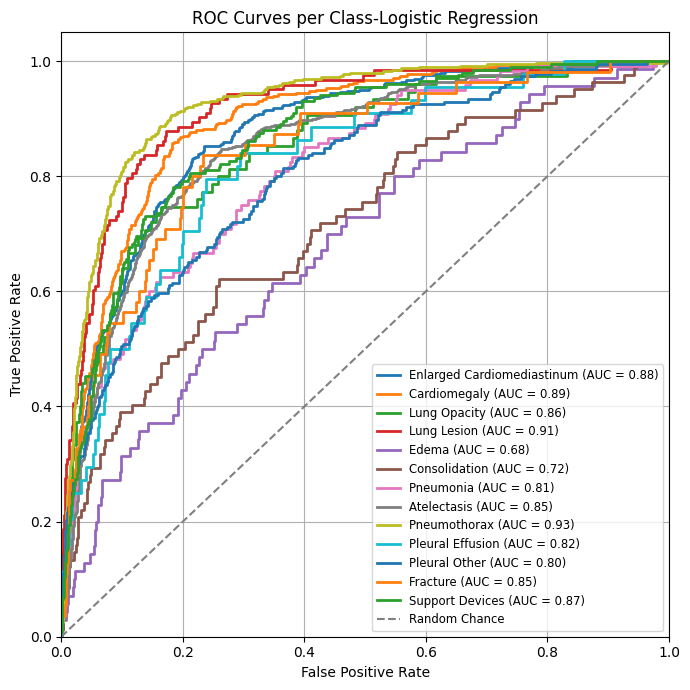

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_truths[i], y_test_probs[i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{pathologies[i]} (AUC = {roc_auc:.2f})')

# Plot chance line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Chance')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Class-Logistic Regression')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


Done for part 1 
Comments: 
- The model shows good performance across several pathology classes, such as Pneumothorax (AUC=0.93). 
- Some classes, such as Edema (AUC = 0.68), exhibit relatively poor performance.
- For classes with low recall (e.g., Edema), tuning the decision threshold may lead to improved recall.
- Next, we are going to explore more complex model (MLP) to capture non-linear patterns, expecting better results. 